In [99]:
# text manipulation
import re
import string

# Data management
import pandas as pd
import numpy as np
from scipy.sparse import *
import scipy

# NLP
import nltk
import nltk.collocations as collocations
from nltk.tag import tnt
import spacy

# modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.cluster import MeanShift

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import matplotlib.style as style 

%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
train.shape

(1306122, 3)

In [5]:
no_insincere = train[train['target']==1].target.count()
no_sincere = train[train['target']==0].target.count()

print('No. of insincere questions:', no_insincere)
print('No. of sincere questions:', no_sincere)
print('% of insincere questions:', train.target.mean())
print('Null score:', 1- train.target.mean())

No. of insincere questions: 80810
No. of sincere questions: 1225312
% of insincere questions: 0.06187017751787352
Null score: 0.9381298224821265


# Data Cleaning

In [6]:
%%time
# remove digits
clean_questions = [''.join(c for c in q if not c.isdigit()) for q in train.question_text]

Wall time: 12.2 s


In [7]:
# replacing all identity labels each question with a common labels
def labels_to_question(data, label_list, label_type):
         
    new_data = []
    
    # For every questions
    i_data = 0
    for i_data in range(len(data)):
        question = data[i_data].lower()
        output = []
        
        # compare each label to question
        for label in label_list:

            if label in question:

                que_t = nltk.word_tokenize(question)
                lab_t = nltk.word_tokenize(label)

                i_que = 0
                while i_que < len(que_t):
                    i_lab = 0
                    
                    # If current token is same as first label token, continue compare rest of the tokens. 
                    if que_t[i_que] == lab_t[0]:
                        que_t[i_que] = label_type
                        i_lab += 1
                        i_que += 1

                        # Remove trailing question tokens if they match trailing label tokens
                        while i_lab < len(lab_t):
                            if que_t[i_que] == lab_t[i_lab]:
                                que_t.pop(i_que)
                                i_lab += 1
                            else:
                                break
#                     elif que_t[i_que] == lab_t[0]:
#                         print('Question: ',question, i_data)
#                         print('label: ', label)
                    i_que += 1
                question = ' '.join(que_t)
#                 print('after: ', question)
#                 print('label: ', label)
        new_data.append(question)                   
        if i_data % 1000 == 0:
            clear_output(wait=True)
            display(i_data)
    return new_data


In [9]:
# Identity groupd filters, created from online lists, most frequent insincere words and manual editing.
ID_filter = pd.read_csv('ID_filter.csv')

In [10]:
ID_filter.head(2)

,RELIGIOUS_ID,RACIAL_ID,NATIONAL_ID,NATIONALITY_ID,GENDER_ID,Unnamed: 5,Political_groups,Political_figure
0,buddhist,white people,Afghanistan,Afghans,girls,NaN,trump supporters,donald trump
1,catholic,black people,Albania,Albanians,boys,NaN,democrate,president trump


In [11]:
religious_ID = ID_filter.RELIGIOUS_ID.dropna()
racial_ID = ID_filter.RACIAL_ID.dropna()
national_ID = ID_filter.NATIONAL_ID.dropna()
nationality_ID = ID_filter.NATIONALITY_ID.dropna()



In [12]:
%%time
clean_questions = labels_to_question(clean_questions, religious_ID, 'RELIGIOUS_ID')
clean_questions = labels_to_question(clean_questions, racial_ID, 'RACIAL_ID')
clean_questions = labels_to_question(clean_questions, national_ID, 'NATIONAL_ID')
clean_questions = labels_to_question(clean_questions, nationality_ID, 'NATIONALITY_ID')

1306000

Wall time: 3min 36s


In [13]:
# q_sample = ['today united states will raise taxes', 'How did donald trump junior manage this']
# label_sample = ('raise','united states', 'donald trump junior')
# temp = labels_to_question(q_sample, label_sample, 'REPLACED')
# temp

In [14]:
stopwords = list(nltk.corpus.stopwords.words('english')) + list(string.punctuation) + ["''", '``','’','“','”', "'s", "'d", "'ll", "'t", "n't", "ca", 'wo']

In [ ]:
%%time
# remove stop words and lower all characters
clean_questions = [' '.join(w for w in nltk.word_tokenize(q.lower()) if w not in stopwords) for q in clean_questions]

In [16]:
len(clean_questions)

1306122

In [41]:
train.question_text[1]

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

In [43]:
clean_questions[:1000]

['how did quebec nationalists see their province as a nation in the s?',
 'do you have an adopted dog, how would you encourage people to adopt and not shop?',
 'why does velocity affect time? does velocity affect space geometry?',
 'how did otto von guericke used the magdeburg hemispheres?',
 'can i convert montra helicon d to a mountain bike by just changing the tyres?',
 'is gaza slowly becoming auschwitz, dachau or treblinka for palestinians?',
 'why does quora automatically ban conservative opinions when reported, but does not do the same for liberal views?',
 'is it crazy if i wash or wipe my groceries off? germs are everywhere.',
 'is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?',
 'is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. how did things change?'

# Define functions and pipelines

In [44]:
def vect_trans(vectorizer, X_train, X_test):
    # can also take a transformer
    vect = vectorizer
    vect.fit(X_train)
    return vect.transform(X_train), vect.transform(X_test)

In [45]:
# MultinominalNB function for printing scores and storing into df.
def model_score(model, X_train, X_test, y_train, y_test, score_df, model_label):
    estimator = model
    estimator.fit(X_train, y_train)
    test_score =  estimator.score(X_test, y_test)
    f1 = f1_score(y_test, estimator.predict(X_test))
    
    print('Train Accuracy :', estimator.score(X_train, y_train))
    print('Test Accuracy:', test_score)
    print('Test F1 score:', f1)
    score_df.loc[model_label, 'Test_Accuracy'] = test_score
    score_df.loc[model_label, 'Test_F1_score'] = f1

In [46]:
# Cross Validate function for printing scores and storing into df.
def cv_score(model, X, y, model_label,  cv=5, ):    
    
    # instantiating model
    estimator = model
    
    cv_result = cross_validate(estimator, X, y, cv = cv, n_jobs=-1, scoring=['accuracy', 'f1'])
    
    print('Test Accuracy Mean:',cv_result['test_accuracy'].mean())
    print('Test Accuracy STD:',cv_result['test_accuracy'].std())
    print('Test F1:', cv_result['test_f1'].mean())
    score_df.loc[model_label, 'CV_Accuracy'] = cv_result['test_accuracy'].mean()
    score_df.loc[model_label, 'CV_Acc_STD'] = cv_result['test_accuracy'].std()
    score_df.loc[model_label, 'CV_F1_score'] = cv_result['test_f1'].mean()

In [47]:
# GridSearchCV function, auto display best score and parameters and storing in df
def gridcv(model, X, y, params, cv= 5 ):
    
    # instantiating model can also be a pipeline
    estimator = model
    
    gridcv = GridSearchCV(estimator=estimator, param_grid=params, cv = cv, verbose=10, n_jobs=6)
    gridcv.fit(X, y)
    
    print(gridcv.best_params_)
    print(gridcv.best_score_)
    

In [48]:
# CountVectorizer pipeline and parameters
pipeCVNB = Pipeline([('CV',CountVectorizer(stop_words=stopwords)), 
                    ('NB',MultinomialNB())])

paramsCVNB = {'CV__max_df':(1.0, 0.9, 0.8, 0.7),
       'CV__min_df': (1, 2, 0.01 , 0.1, 0.2),
         'CV__ngram_range':((1,1), (1,2), (1,3))}

In [49]:
# TfidfVectorizer pipeline and parameters
pipeTVNB = Pipeline([('TV',TfidfVectorizer(stop_words=stopwords)), 
                    ('NB',MultinomialNB())])

paramsTVNB = {'TV__max_df':(1.0, 0.9, 0.8, 0.7, 0.6),
       'TV__min_df': (1, 2, 0.01, 0.05, 0.1),
         'TV__ngram_range':((1,1), (1,2), (1,3), (2,2), (2,3))}

In [50]:
score_df = pd.DataFrame()

# Default count vectorizer on raw text

In [51]:
%%time

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(train.question_text, train.target,
                                                                    stratify=train.target, random_state = 495)

X_train_raw_t, X_test_raw_t=  vect_trans(CountVectorizer(), X_train_raw, X_test_raw)

Wall time: 35.4 s


In [52]:
model = MultinomialNB()
model_label = 'Raw_token_NB'

model_score(model, X_train_raw_t, X_test_raw_t, y_train_raw, y_test_raw, score_df, model_label)
cv_score(model, X_train_raw_t, y_train_raw, model_label)
score_df

Train Accuracy : 0.9350739237089765
Test Accuracy: 0.9344135778838762
Test F1 score: 0.5646092542896641
Test Accuracy Mean: 0.9321614838567932
Test Accuracy STD: 0.0005228593021778298
Test F1: 0.5489215714930169


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922


In [53]:
nb = MultinomialNB()
nb.fit(X_train_raw_t, y_train_raw)  
test_score =  nb.score(X_test_raw_t, y_test_raw)
print('train score:', nb.score(X_train_raw_t, y_train_raw))
print('test score:', test_score)
y_pred = nb.predict(X_test_raw_t)

train score: 0.9350739237089765
test score: 0.9344135778838762


In [54]:
print(f1_score(y_test_raw, y_pred) )
print(f1_score(y_test_raw, y_pred, average='macro') )
print(f1_score(y_test_raw, y_pred, average='micro') )
print(f1_score(y_test_raw, y_pred, average='weighted') )
confusion_matrix(y_test_raw, y_pred)

0.5646092542896641
0.7645724512273393
0.9344135778838762
0.9397915566837656


array([[291229,  15099],
       [  6317,  13886]], dtype=int64)

# Basic Token and Ngram modelling on cleaned data

Creating train/test sets

In [55]:
X = clean_questions
y = train.target

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 495)

### Tokens only

In [57]:
%%time
X_train_t, X_test_t=  vect_trans(CountVectorizer(max_df=1.0, min_df=1, ngram_range=(1,1)), X_train, X_test)

Wall time: 32.7 s


In [58]:
model = MultinomialNB()
model_label = 'Token_NB'
X_train_arg = X_train_t
X_test_arg = X_test_t

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

Train Accuracy : 0.9342000896292433
Test Accuracy: 0.9335132039530704
Test F1 score: 0.5615735692071571
Test Accuracy Mean: 0.9312692746998665
Test Accuracy STD: 0.0005412122745367851
Test F1: 0.5469019096807259


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.933513,0.561574,0.931269,0.000541,0.546902


### All Bigrams

In [59]:
%%time
X_train_bi, X_test_bi=  vect_trans(CountVectorizer(ngram_range=(1,2)), X_train, X_test)

Wall time: 1min 27s


Naive Bayes

In [61]:
model = MultinomialNB()
model_label = 'Bigram_NB'
X_train_arg = X_train_bi
X_test_arg = X_test_bi

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

Train Accuracy : 0.9605151537733605
Test Accuracy: 0.9484306237386343
Test F1 score: 0.5147402092158727
Test Accuracy Mean: 0.9405425336098666
Test Accuracy STD: 0.00034472274054820435
Test F1: 0.5050867545625731


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.933513,0.561574,0.931269,0.000541,0.546902
Bigram_NB,0.948431,0.514740,0.940543,0.000345,0.505087


Random Forest

In [ ]:
# %%time
# model = RandomForestClassifier(n_estimators= 100, max_depth=20, n_jobs=-1)
# model_label = 'Bigram_RF'


# model_score(model, X_train_bi, X_test_bi, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_bi, y_train, model_label)
# score_df

In [ ]:
# score_df

### Tri-gram

In [62]:
%%time
X_train_tri, X_test_tri=  vect_trans(CountVectorizer(ngram_range=(1,3), stop_words=stopwords), X_train, X_test)

Wall time: 1min 44s


Naive Bayes

In [66]:
model = MultinomialNB()
model_label = 'Trigram_NB'
X_train_arg = X_train_tri
X_test_arg = X_test_tri

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

Train Accuracy : 0.9877755103915818
Test Accuracy: 0.9445718783208945
Test F1 score: 0.2688159011028966
Test Accuracy Mean: 0.9444206818481715
Test Accuracy STD: 0.0003769540695862718
Test F1: 0.5028029677561217


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.933513,0.561574,0.931269,0.000541,0.546902
Bigram_NB,0.948431,0.514740,0.940543,0.000345,0.505087
Trigram_NB,0.944572,0.268816,0.944421,0.000377,0.502803


Random Forest

In [ ]:
# %%time
# model = RandomForestClassifier(n_estimators= 100, max_depth=20, n_jobs=-1)
# model_label = 'Trigram_RF'

# model_score(model, X_train_tri, X_test_tri, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_tri, y_train, model_label)


In [ ]:
# score_df

### GridSearch min/max df

In [ ]:
# params = {'CV__max_df':(1.0, 0.9),
#        'CV__min_df': (1, 2, 0.01, 0.02),
#         'CV__ngram_range':((1,1), (1,2), (1,3))}

# gridcv(pipeCVNB, X_train, y_train, params)

In [ ]:
# %%time
# X_train_t, X_test_t=  vect_trans(CountVectorizer(max_df=1.0, min_df=1, ngram_range=(1,2), 
#                                                     stop_words=stopwords), X_train, X_test)

In [ ]:
# model = MultinomialNB()
# model_label = 'Grid_DFNB'

# model_score(model, X_train_t, X_test_t, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_t, y_train, model_label)
# score_df

### TFIDF

In [67]:
X_train_tf_t, X_test_tf_t = vect_trans(TfidfTransformer(), X_train_t, X_test_t)

In [68]:
model = MultinomialNB()
model_label = 'Tfidf_t_NB'

model_score(model, X_train_tf_t , X_test_tf_t, y_train, y_test, score_df, model_label)
cv_score(model, X_train_tf_t, y_train, model_label)
score_df

Train Accuracy : 0.9421003255440281
Test Accuracy: 0.9408172577795064
Test F1 score: 0.11022606934020904
Test Accuracy Mean: 0.9397738446164585
Test Accuracy STD: 0.00017236565380319963
Test F1: 0.0821610873024041


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.933513,0.561574,0.931269,0.000541,0.546902
Bigram_NB,0.948431,0.514740,0.940543,0.000345,0.505087
Trigram_NB,0.944572,0.268816,0.944421,0.000377,0.502803
Tfidf_t_NB,0.940817,0.110226,0.939774,0.000172,0.082161


In [69]:
nb = MultinomialNB()
nb.fit(X_train_tf_t, y_train)  
test_score =  nb.score(X_test_tf_t, y_test)
print('train score:', nb.score(X_train_tf_t, y_train))
print('test score:', test_score)
y_pred = nb.predict(X_test_tf_t)

train score: 0.9421003255440281
test score: 0.9408172577795064


In [70]:
print(f1_score(y_test, y_pred) )
print(f1_score(y_test, y_pred, average='macro') )
print(f1_score(y_test, y_pred, average='micro') )
print(f1_score(y_test, y_pred, average='weighted') )
confusion_matrix(y_test, y_pred)

0.11022606934020904
0.5398083587649309
0.9408172577795064
0.9162327489810163


array([[306009,    319],
       [ 19006,   1197]], dtype=int64)

### NLTK Best Bigrams

In [71]:
# recreate text using ngrams
def ngram_to_corpus(data, ngram_list, n):
#     ngram_list = set({('let', 'us'), ('as', 'soon')})  # {('let', 'us'), ('as', 'soon')}
#     tokens = ['please', 'let', 'us', 'know', 'as', 'soon', 'as', 'possible']
    new_data = []
    for text in data:
        tokens = nltk.word_tokenize(text)
        output = []
        q_iter = iter(range(len(tokens)))
        
        for idx in q_iter:
            output.append(tokens[idx])
            if n == 2:
                if idx < (len(tokens) - 1) and (tokens[idx], tokens[idx+1]) in ngram_list:
                    output[-1] += '_' + tokens[idx+1]
                    next(q_iter)
            elif n == 3:
                if idx < (len(tokens) - 2) and (tokens[idx], tokens[idx+1], tokens[idx+2] ) in ngram_list:
                    output[-1] += '_' + tokens[idx+1] + '_' + tokens[idx+2]
                    next(q_iter)
                    next(q_iter)
        new_data.append( ' '.join(output))

    return new_data

In [72]:
%%time
# create one list of all question tokens
full_text = []

for text in X_train:
    full_text += [w for w in nltk.word_tokenize(text) if w not in stopwords]

Wall time: 2min 47s


In [73]:
len(full_text)

6223173

In [75]:
%%time
# create bigram vocabulary
bigram_measures = collocations.BigramAssocMeasures()

finder = nltk.BigramCollocationFinder.from_words(full_text)
# scored = finder.score_ngrams( bigram_measures.likelihood_ratio  )
bigram_vocab = finder.nbest(bigram_measures.likelihood_ratio, 80)
print(bigram_vocab)

[('united', 'states'), ('best', 'way'), ('donald', 'trump'), ('year', 'old'), ('computer', 'science'), ('even', 'though'), ('high', 'school'), ('would', 'happen'), ('social', 'media'), ('north', 'korea'), ('pros', 'cons'), ('get', 'rid'), ('major', 'accomplishments'), ('jee', 'mains'), ('look', 'like'), ('would', 'win'), ('new', 'york'), ('machine', 'learning'), ('harry', 'potter'), ('years', 'old'), ('real', 'estate'), ('long', 'take'), ('saudi', 'arabia'), ('feel', 'like'), ('star', 'wars'), ('ssc', 'cgl'), ('mechanical', 'engineering'), ('elon', 'musk'), ('tv', 'show'), ('hillary', 'clinton'), ('hong', 'kong'), ('tamil', 'nadu'), ('president', 'trump'), ('useful', 'tips'), ('san', 'francisco'), ('different', 'types'), ('hotels', 'short-term'), ('artificial', 'intelligence'), ('prime', 'minister'), ('years', 'ago'), ('literary', 'devices'), ('tv', 'series'), ('credit', 'card'), ('narendra', 'modi'), ('many', 'people'), ('digital', 'marketing'), ('new', 'zealand'), ('los', 'angeles'),

In [76]:
%%time
# create bigram vocabulary
bigram_measures = collocations.BigramAssocMeasures()


finder3 = nltk.BigramCollocationFinder.from_words(full_text)
finder3.apply_freq_filter(10)
finder3.apply_word_filter(lambda x: x in stopwords)
best_pmi = finder3.nbest(bigram_measures.pmi, 200)
print(best_pmi)

[('jiu', 'jitsu'), ('muhoozi', 'kainerugaba'), ('neman', 'ashraf'), ('roald', 'dahl'), ('rudyard', 'kipling'), ('michio', 'kaku'), ('avada', 'kedavra'), ('aam', 'aadmi'), ('buenos', 'aires'), ('jaggi', 'vasudev'), ('disha', 'patani'), ('deng', 'xiaoping'), ('ronda', 'rousey'), ('abercrombie', 'fitch'), ('zaira', 'wasim'), ('endoplasmic', 'reticulum'), ('nathuram', 'godse'), ('sushma', 'swaraj'), ('jiang', 'zemin'), ('vande', 'mataram'), ('meryl', 'streep'), ('pakatan', 'harapan'), ('asim', 'qureshi'), ('sylvia', 'plath'), ('lata', 'mangeshkar'), ('dima', 'vorobiev'), ('kalpit', 'veerwal'), ('sindhu', 'satish'), ('pradhan', 'mantri'), ('aldous', 'huxley'), ('narsee', 'monjee'), ('ulcerative', 'colitis'), ('gauri', 'lankesh'), ('hadron', 'collider'), ('ballon', "d'or"), ('mitt', 'romney'), ('petyr', 'baelish'), ('shel', 'silverstein'), ('khaled', 'hosseini'), ('sourav', 'ganguly'), ('satoshi', 'nakamoto'), ('tubal', 'ligation'), ('satya', 'nadella'), ('agatha', 'christie'), ('klux', 'kla

In [77]:
%%time
# create trigram vocabulary
trigram_measures = collocations.TrigramAssocMeasures()
finder = nltk.TrigramCollocationFinder.from_words(full_text)
trigram_vocab = finder.nbest(trigram_measures.likelihood_ratio, 20)
print(trigram_vocab)

[('united', 'states', 'america'), ('president', 'united', 'states'), ('united', 'states', 'india'), ('states', 'united', 'states'), ('history', 'united', 'states'), ('united', 'states', 'constitution'), ('united', 'states', 'government'), ('united', 'states', 'matter'), ('united', 'states', 'like'), ('united', 'states', 'army'), ('united', 'states', 'us'), ('united', 'states', 'usa'), ('united', 'states', 'united'), ('south', 'united', 'states'), ('coast', 'united', 'states'), ('canada', 'united', 'states'), ('united', 'states', 'military'), ('united', 'states', 'marine'), ('outside', 'united', 'states'), ('happen', 'united', 'states')]
Wall time: 8min 53s


In [78]:
%%time
# create text with bigram replacement
train['bigram_question_lkhd'] = ngram_to_corpus(clean_questions, bigram_vocab, 2)

Wall time: 4min 5s


In [79]:
%%time
# create text with both tri and bigram in text, by applying trigram first
train['trigram_question_lkhd'] = ngram_to_corpus(clean_questions, trigram_vocab, 3)
train['trigram_question_lkhd'] = ngram_to_corpus(train['trigram_question_lkhd'], bigram_vocab, 2)

Wall time: 7min 37s


In [80]:
train['trigram_question_lkhd'][20:25].values

array(['how i know whether a girl had done sex before sex with me ?',
       'how do i become a fast learner both in my professional career and in my personal life ?',
       'has the united_states become the largest dictatorship in the world ?',
       'what is the strangest phenomenon you know of , have witnessed or have generated in the area of electronics that has no explanation in terms of modern physics ?',
       'should i leave my friends and find new ones ?'], dtype=object)

In [81]:
X = train[['bigram_question_lkhd','trigram_question_lkhd']]
y = train.target

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=495, test_size=0.2)

In [83]:
len(X_train)

1044897

In [84]:
X_train.head()

,bigram_question_lkhd,trigram_question_lkhd
1077331,what is the procedure of officially changing n...,what is the procedure of officially changing n...
334276,what is the ancient egypt polytheism ?,what is the ancient egypt polytheism ?
620299,"whenever i put on the blood pressure monitor ,...","whenever i put on the blood pressure monitor ,..."
1098236,how does the ego react to suicide ?,how does the ego react to suicide ?
548923,how do i join tcs as a fresher if i missed off...,how do i join tcs as a fresher if i missed off...


#### Bigram Model

In [85]:
# model using bigram text
X_train_bi, X_test_bi =  vect_trans(CountVectorizer(max_df=1.0,  min_df=1, ngram_range=(1,1), stop_words=stopwords),
                                   X_train.bigram_question_lkhd, X_test.bigram_question_lkhd,)



In [87]:
model = MultinomialNB()
model_label = 'Bigram_best_NB'

model_score(model, X_train_bi, X_test_bi, y_train, y_test, score_df, model_label)
cv_score(model, X_train_bi, y_train, model_label)
score_df

Train Accuracy : 0.9380359978064824
Test Accuracy: 0.9372724662647143
Test F1 score: 0.5531253408966947
Test Accuracy Mean: 0.9327885912694457
Test Accuracy STD: 0.0004463320545615013
Test F1: 0.5290648950920555


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.933513,0.561574,0.931269,0.000541,0.546902
Bigram_NB,0.948431,0.514740,0.940543,0.000345,0.505087
Trigram_NB,0.944572,0.268816,0.944421,0.000377,0.502803
Tfidf_t_NB,0.940817,0.110226,0.939774,0.000172,0.082161
Bigram_best_NB,0.937272,0.553125,0.932789,0.000446,0.529065


#### Trigram Model

In [88]:
# model using bigram text
X_train_tri, X_test_tri =  vect_trans(CountVectorizer(max_df=1.0,  min_df=1, ngram_range=(1,1), stop_words=stopwords),
                                   X_train.trigram_question_lkhd, X_test.trigram_question_lkhd)



In [90]:
model = MultinomialNB()
model_label = 'Trigram_best_NB'

model_score(model, X_train_tri, X_test_tri, y_train, y_test, score_df, model_label)
cv_score(model, X_train_tri, y_train, model_label)
score_df

Train Accuracy : 0.9380369548386109
Test Accuracy: 0.9372686381471911
Test F1 score: 0.5531102566200333
Test Accuracy Mean: 0.9327838060950644
Test Accuracy STD: 0.00044240760698066844
Test F1: 0.5290408100038101


,Test_Accuracy,Test_F1_score,CV_Accuracy,CV_Acc_STD,CV_F1_score
Raw_token_NB,0.934414,0.564609,0.932161,0.000523,0.548922
Token_NB,0.933513,0.561574,0.931269,0.000541,0.546902
Bigram_NB,0.948431,0.514740,0.940543,0.000345,0.505087
Trigram_NB,0.944572,0.268816,0.944421,0.000377,0.502803
Tfidf_t_NB,0.940817,0.110226,0.939774,0.000172,0.082161
Bigram_best_NB,0.937272,0.553125,0.932789,0.000446,0.529065
Trigram_best_NB,0.937269,0.553110,0.932784,0.000442,0.529041


In [92]:
# score_df.to_pickle('./identity_score.pkl')

In [93]:
score_df = pd.read_pickle('./identity_score.pkl')

In [94]:
acc_df = pd.DataFrame(index=['Baseline','Raw Token', 'Tokens', 'All Bigram', 'All Trigram', 'TFIDF', 'N Bigram', 'N Trigram'])
acc_df['Accuracy'] = acc_list = [1-train.target.mean()] + list(score_df['Test_Accuracy'])


In [95]:
f1_df =  pd.DataFrame(index=['Raw Token', 'Tokens', 'All Bigram', 'All Trigram', 'TFIDF', 'N Bigram', 'N Trigram'])
f1_df['F1 Score'] = list(score_df['Test_F1_score'])


In [100]:
style.use('seaborn-poster')

style.use('seaborn-whitegrid') #sets the size of the charts
style.use('tableau-colorblind10')

In [101]:
f1_hue = sns.color_palette("Set3")
acc_hue  = sns.color_palette("Set3")
acc_hue.insert(0, (.7,.7,.7))

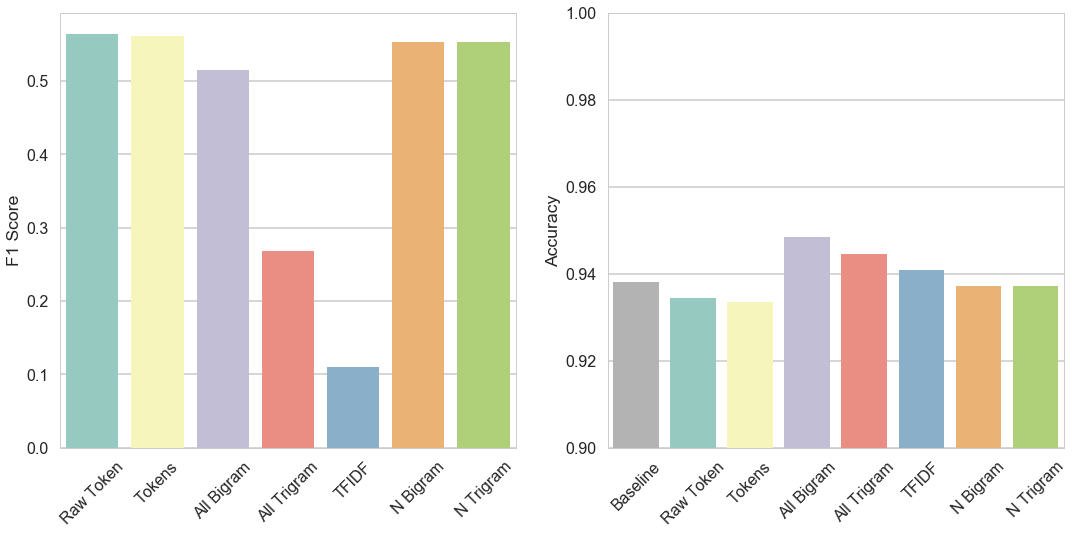

In [102]:
fig, ax = plt.subplots(1,2, figsize=(18,8))

ax1 = plt.subplot(121)
ax1 = sns.barplot(x=f1_df.index, y=f1_df['F1 Score'], palette=f1_hue)
ax1 = plt.xticks(rotation=45)

ax2 = plt.subplot(122)
ax2 = sns.barplot(x=acc_df.index, y=acc_df.Accuracy, palette=acc_hue)
ax1 = plt.ylim(0.9, 1)
ax2 = plt.xticks(rotation=45)


